# Trying to process a sample of images in parallel

In [1]:
import sys
import os
import random
import glob
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
import math
import matplotlib
import matplotlib.pyplot as plt
import gc
%matplotlib inline

In [2]:
import time

In [3]:
from skimage.feature import hog
from skimage import data,exposure

In [4]:
from tqdm import tqdm
from time import sleep

In [5]:
from bcolz import carray

In [6]:
from joblib import Parallel, delayed

In [7]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [8]:
args={"shape_predictor":"shape_predictor_68_face_landmarks.dat"}
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(args["shape_predictor"])

#### Compute functions

In [9]:
# Read points from text files in directory
def readPoints(path) :
    pointsArray = [];
    points = [];   
#     print(path)
    with open(path) as file :
        for line in file :
            x, y = line.split()
            points.append((int(float(x)), int(float(y))))
    pointsArray.append(points)
    return pointsArray;

# Read all jpg images in folder.
def readImages(path) :
    imagesArray = [];
    img = cv2.imread(path);
    img = np.float32(img)/255.0;
    imagesArray.append(img);
    return imagesArray;
                
# Compute similarity transform given two sets of two points, OpenCV requires 3 pairs of corresponding points, we are faking the third one.
def similarityTransform(inPoints, outPoints) :
    s60 = math.sin(60*math.pi/180);
    c60 = math.cos(60*math.pi/180);  
  
    inPts = np.copy(inPoints).tolist();
    outPts = np.copy(outPoints).tolist();
    
    xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0];
    yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1];
    
    inPts.append([np.int(xin), np.int(yin)]);
    
    xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0];
    yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1];
    
    outPts.append([np.int(xout), np.int(yout)]);
    
    tform = cv2.estimateRigidTransform(np.array([inPts]), np.array([outPts]), False);
    
    return tform;

#### Image Preprocessing functions to try.


Mainly 4 functions that can be used:
    - detectAndaligncrop:
        Reads the image, detects face, aligns and crops
    - detectAndaligncrop2: (Reads the image as grayscale directly(doesn't use the cvtcolor function) )
        Reads the image, detects face, aligns and crops
    - rgbTogray:
        Convert to gray using cvtcolor
    - rgbTogray:
        Read as gray directly and return it.

The code is in such a form so that refactoring allows calculating average landmarks for multiple images

In [10]:
#new function, doesnt write landmarks every single time
def detectAndaligncrop(impath):
    
    try:
        # reading image
        image=cv2.imread(impath)
        image_float=np.float32(image)/255.0
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #     print("postgray")
        rects = detector(gray, 1)

        #detecting points
        #initialising images and allPoints arrays
        allPoints=[]
        for (i, rect) in enumerate(rects):
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            points=[]
            for (x,y) in shape:
                points.append((x,y))
    #             print(x,y)
            allPoints.append(points)
        images=[image_float]

        #computation
        w=112
        h=112
        eyecornerDst = [ (np.int(0.3 * w ), np.int(h / 3)), (np.int(0.7 * w ), np.int(h / 3)) ];
        imagesNorm = [];
        pointsNorm = [];
        #     print allPoints[0]
        # Add boundary points for delaunay triangulation
        boundaryPts = np.array([(0,0), (w/2,0), (w-1,0), (w-1,h/2), ( w-1, h-1 ), ( w/2, h-1 ), (0, h-1), (0,h/2) ]);
        n = len(allPoints[0]);
        numImages = len(images)
        for i in xrange(0, numImages):
            points1 = allPoints[i];
            # Corners of the eye in input image
            eyecornerSrc  = [ allPoints[i][36], allPoints[i][45] ] ;
            # Compute similarity transform
            tform = similarityTransform(eyecornerSrc, eyecornerDst);
            # Apply similarity transformation
            img = cv2.warpAffine(images[i], tform, (w,h));
        #         print("debug im type shape max mean min ", img.dtype,img.shape,np.max(img),np.mean(img),np.min(img))
        #         plt.imshow(img)
            # Apply similarity transform on points
            points2 = np.reshape(np.array(points1), (68,1,2));        
            points = cv2.transform(points2, tform);
            points = np.float32(np.reshape(points, (68, 2)));
            pointsNorm.append(points);
            imagesNorm.append(img);
        #     print (pointsNorm[0])
        #     plt.imshow(imagesNorm[0]) 

        # Output image
        output=imagesNorm[0]
        rgb_image=cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
        print("Computation for detectAndaligncrop done")
        return rgb_image, pointsNorm[0]
    except:
        print("error in Computation for detectAndaligncrop")
        return None,None

In [11]:
#new function, doesnt write landmarks every single time
def detectAndaligncrop2(impath):
    
    try:
        # reading image
        gray = cv2.imread(impath,0)
        image = cv2.imread(impath)
        image_float=np.float32(image)/255.0
    #     print("postgray")
        rects = detector(gray, 1)

        #detecting points
        #initialising images and allPoints arrays
        allPoints=[]
        for (i, rect) in enumerate(rects):
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            points=[]
            for (x,y) in shape:
                points.append((x,y))
    #             print(x,y)
            allPoints.append(points)
        images=[image_float]

        #computation
        w=112
        h=112
        eyecornerDst = [ (np.int(0.3 * w ), np.int(h / 3)), (np.int(0.7 * w ), np.int(h / 3)) ];
        imagesNorm = [];
        pointsNorm = [];
        #     print allPoints[0]
        # Add boundary points for delaunay triangulation
        boundaryPts = np.array([(0,0), (w/2,0), (w-1,0), (w-1,h/2), ( w-1, h-1 ), ( w/2, h-1 ), (0, h-1), (0,h/2) ]);
        n = len(allPoints[0]);
        numImages = len(images)
        for i in xrange(0, numImages):
            points1 = allPoints[i];
            # Corners of the eye in input image
            eyecornerSrc  = [ allPoints[i][36], allPoints[i][45] ] ;
            # Compute similarity transform
            tform = similarityTransform(eyecornerSrc, eyecornerDst);
            # Apply similarity transformation
            img = cv2.warpAffine(images[i], tform, (w,h));
        #         print("debug im type shape max mean min ", img.dtype,img.shape,np.max(img),np.mean(img),np.min(img))
        #         plt.imshow(img)
            # Apply similarity transform on points
            points2 = np.reshape(np.array(points1), (68,1,2));        
            points = cv2.transform(points2, tform);
            points = np.float32(np.reshape(points, (68, 2)));
            pointsNorm.append(points);
            imagesNorm.append(img);
        #     print (pointsNorm[0])
        #     plt.imshow(imagesNorm[0]) 

        # Output image
        output=imagesNorm[0]
        rgb_image=cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
        print("Computation for detectAndaligncrop2 done")
        return rgb_image, pointsNorm[0]
    except:
        print("error in Computation for detectAndaligncrop2")
        return None, None

In [12]:
def rgbToGray(impath):
    gray="sample"
    try:
        image=cv2.imread(impath)
    #     gray=cv2.imread(impath,0)
        image_float=np.float32(image)/255.0
#         print("before gray")
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Computation for rgbToGray done")
    except:
        print("error in Computation for rgbToGray")
#     print("returning")
    return gray,1

In [13]:
def rgbToGray2(impath):
    gray="sample"
    try:
#         image=cv2.imread(impath)
        gray=cv2.imread(impath,0)
#         image_float=np.float32(image)/255.0
#         print("before gray")
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Computation for rgbToGray2 done")
    except:
        print("error in Computation for rgbToGray")
#     print("returning")
    return gray,1

In [14]:
def detectAlignCropSave(im_path,path_dest="/media/amogh/Stuff/CMU/datasets/sample/cropped2"):
    try:
        im,lm=detectAndaligncrop(im_path)
        fname="{}/{}".format(path_dest,os.path.basename(im_path))
        cv2.imwrite(fname,im*255.)
        return 0
    except:
        print("error here")
        return 1

## Testing preprocessing on sample images

In [15]:
# imageTouse='/media/amogh/Stuff/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S999/003/S999_003_00000055.png'
# imageTouse='/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN013/001.jpeg'
# imageTouse='/home/amogh/cmu/dataset/BP4D/BP4D-training/F001/T1/2440.jpg' #BP4D images
imageTouse="files_may20/1.jpeg" #DISFA sample images
# imageTouse='/media/amogh/OS/Users/AMOGH GUPTA/Desktop/CMU/Face Alignment/FaceAverage/presidents/barak-obama.jpg'

Computation for detectAndaligncrop done


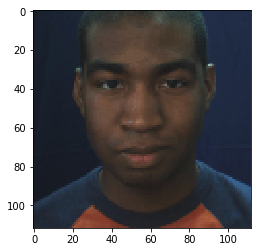

In [16]:
def showSample(imageTouse):
    sample_alignedAndCropped,landmarkPoints=detectAndaligncrop(imageTouse)
    plt.imshow(sample_alignedAndCropped)
showSample(imageTouse)

In [18]:
#list of sample files to test on
sample_files_list=glob.glob("/media/amogh/Stuff/CMU/datasets/sample/*")
sample_files_list

['/media/amogh/Stuff/CMU/datasets/sample/42.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/14.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/15.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/16.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/21.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/22.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/23.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/26.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/27.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/28.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/29.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/30.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/33.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/34.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/35.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/36.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/37.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/38.jpeg',
 '/media/amogh/Stuff/CMU/datasets/sample/39.jpeg',
 '/media/amogh/Stuff/CMU/datase

### Running Experiments

**Different experiments to try:**
For all, try saving and not saving the images; try simple opencv function; try a combination of opencv and dlib preprocessing
- No parallelisation 
- Multiprocessing
- Concurrent futures
- Multithreading 
- Joblib

##### No Parallelisation

In [19]:
def testNoParallel(files_list,func,write=False, write_dest="/media/amogh/Stuff/CMU/datasets/sample/cropped1"):
    """Detect landmarks, crop and align the image, option-to write"""
    start_time=time.time()
    for im in files_list:
#         try:
        cropped_im, _ = func(im)
        if write:
            cv2.imwrite("{}/{}".format(write_dest,os.path.basename(im)),cropped_im*255.)
#         except:
#             print("__error__")
#             continue
    print("done, and the time taken is: ", time.time()-start_time)
testNoParallel(sample_files_list,rgbToGray) #0.73
testNoParallel(sample_files_list,rgbToGray2) #0.183
#
testNoParallel(sample_files_list,detectAndaligncrop) #15.8

testNoParallel(sample_files_list,detectAndaligncrop2) #15.11

Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computation for rgbToGray done
Computat

##### Multiprocessing

In [101]:
def testMultiprocessing(files_list,func):
    start_time=time.time()
    return_images=multiprocessing.Queue()
    jobs=[]
    for im_no, im in enumerate(files_list):
        p=multiprocessing.Process(target=func,args=[im])
        jobs.append(p)
        p.start()
    for j in jobs:
        j.join()
#     print(jobs)
    print("done, and the time taken is: ", time.time()-start_time)

# testMultiprocessing(sample_files_list, rgbToGray) #doesnt work(because of cvtColor2 Gray)
testMultiprocessing(sample_files_list, rgbToGray2) #0.532 seconds
# testMultiprocessing(sample_files_list, detectAndaligncrop) #doesnt work(because of cvtColor2 Gray)
testMultiprocessing(sample_files_list, detectAndaligncrop2) #4.606 seconds

Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computat

**ProcessPoolExecutor seems like the best way**

In [27]:
def testProcessPoolExecutor(files_list, func, max_workers=multiprocessing.cpu_count()):
    start_time=time.time()
    with ProcessPoolExecutor(max_workers) as execr:
        res=execr.map(func,files_list)
#     print(res)
    print("done, and the time is: ", time.time() - start_time)

# 8 workers :
testProcessPoolExecutor(sample_files_list, rgbToGray2,8) #0.3 seconds
testProcessPoolExecutor(sample_files_list, detectAndaligncrop2,8) #4.62 seconds

# 4 workers :
testProcessPoolExecutor(sample_files_list, rgbToGray2,4) #0.2515
testProcessPoolExecutor(sample_files_list, detectAndaligncrop2,4) #05.04

# 2 workers :
testProcessPoolExecutor(sample_files_list, rgbToGray2,2) #0.2913
testProcessPoolExecutor(sample_files_list, detectAndaligncrop2,2) #8.63

# 1 workers :
testProcessPoolExecutor(sample_files_list, rgbToGray2,1) #0.48
testProcessPoolExecutor(sample_files_list, detectAndaligncrop2,1) #16

Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computat

In [28]:
def testMultiProcessingPool(files_list,func,max_workers=4):
    start_time=time.time()
    pool=multiprocessing.Pool(max_workers)
#     try:
    res=pool.map(func,files_list)
#     except:
#     print("error")
#     print(res)
    print("done, and the time is: ", time.time() - start_time)
testMultiProcessingPool(sample_files_list, rgbToGray2,4) #0.166
testMultiProcessingPool(sample_files_list, detectAndaligncrop2,4) #5.705

Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computat

In [ ]:
def testThreadPoolExecutor(files_list,func,max_workers=4):
    start_time=time.time()
    with ThreadPoolExecutor(max_workers) as execr:
        res = execr.map(func,files_list)
    print("done, and the time is: ", time.time() - start_time)
testThreadPoolExecutor(sample_files_list, rgbToGray2,4) #0.06
testThreadPoolExecutor(sample_files_list, detectAndaligncrop2,4) 

Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
 Computation for rgbToGray2 done
Computation for rgbToGray2 doneComputation for rgbToGray2 done

Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 doneComputation for rgbToGray2 done

Computation for rgbToGray2 doneComputation for rgbToGray2 done

Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 doneComputation for rgbToGray2 done

Computation for rgbToGray2 doneComputation for rgbToGray2 done

Computation for rgbToGray2 done
 Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 doneComputation for rgbToGray2 done

Computation for rgbToGray2 done
Computation for rgbToGray2 done
Computation for rgbToGray2 done
Comput

In [37]:
def testJoblibParallel(files_list,func,max_workers=4):
    start_time=time.time()
    res = []
    res.extend(Parallel(n_jobs=4)(delayed(func)(im) for im in files_list))
#     with ThreadPoolExecutor(max_workers) as execr:
#         res = execr.map(func,files_list)
#     print(res)
    print("done, and the time is: ", time.time() - start_time)
testJoblibParallel(sample_files_list, rgbToGray,1)

('done, and the time is: ', 0.5376260280609131)


In [39]:
testJoblibParallel(sample_files_list, detectAlignCropSave,1)

KeyboardInterrupt: 

#### Conclusion :

For now, simply use imread(path, 0).

There seems to be some problem with cvtColor not working when run on a pool, it seems to be running fine on a thread.

Joblib does a pretty decent job, alhtough throws error in the end. It prints the messages inside the function only when there is 1 thread.

Might have something to do with joblib using pickle internally. Find and fix memory leak.